In [1]:
from configs.config import Config
from src.datasets.course_dataset import CourseDataset, course_collate_fn
from src.models.rqvae import RQVAE
from pathlib import Path
import torch 
from torch.utils.data import DataLoader
from collections import Counter 
import matplotlib.pyplot as plt

In [2]:
MODEL_NAME = "ssa_10_50_250"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = Config()
epoch = cfg.train.epochs
model_path = cfg.train.outputs_dir / MODEL_NAME / "checkpoints" / f"model_{epoch}.pth"
if not Path(model_path).exists():
    raise FileNotFoundError(f"Model checkpoint not found at {model_path}")

model = RQVAE(cfg.model)
model.load_state_dict(torch.load(model_path))
print(model)

RQVAE(
  (enc): MLP(
    (net): Sequential(
      (0): Linear(in_features=1536, out_features=1024, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (vqs): ModuleList(
    (0-2): 3 x VQ()
  )
  (dec): MLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, t

In [3]:
dataset = CourseDataset(cfg.data)
dataloader = DataLoader(
    dataset,
    batch_size=cfg.train.batch_size,
    shuffle=True,
    collate_fn=course_collate_fn,
    num_workers=cfg.train.num_workers,
    pin_memory=cfg.train.pin_memory,
)

print(len(dataset))

132214


In [10]:
all_indices = [Counter() for _ in cfg.model.codebook_sizes]
model.eval()
model.to(device)

unique_outs = set()
with torch.no_grad():
    for batch in dataloader:
        x = batch["embedding"].to(device)
        out = model(x)
        indices = out.indices
        unique_outs.update(indices.cpu().numpy().flatten())
        for i in range(indices.shape[1]):
            all_indices[i].update(indices[:, i].cpu().tolist())
print(len(unique_outs))


4


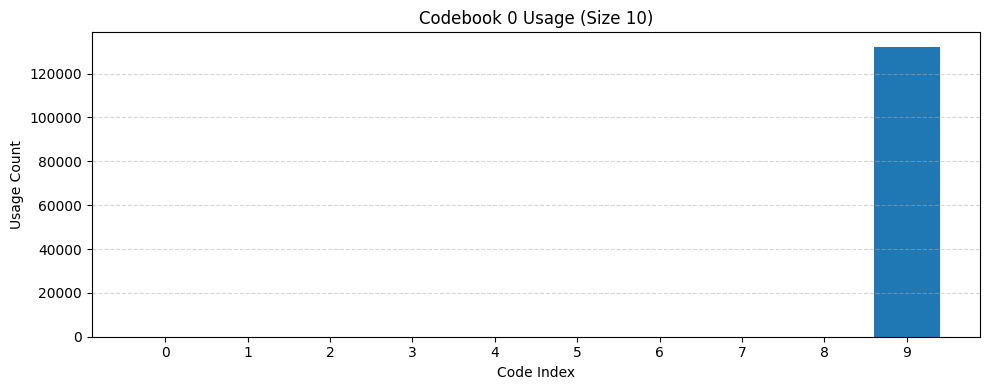

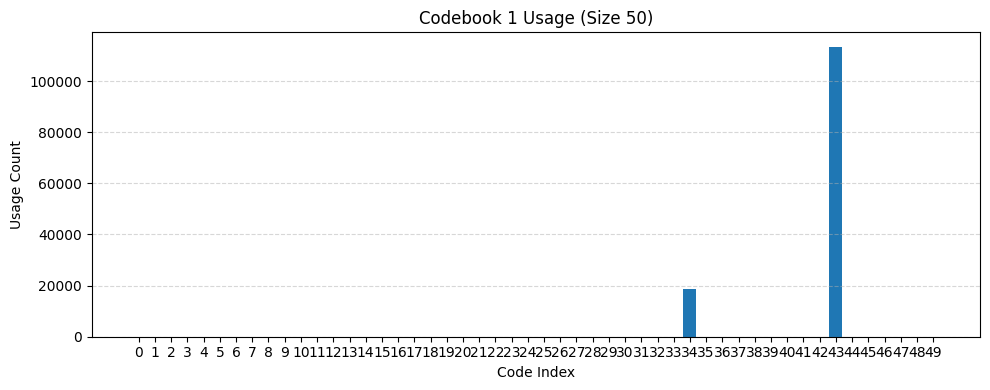

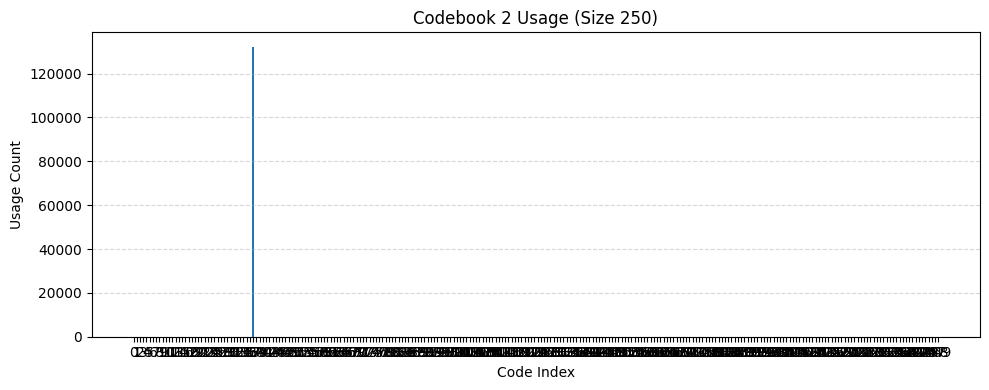

In [9]:
for i, (size, counts) in enumerate(zip(cfg.model.codebook_sizes, all_indices)):
    keys = list(range(size))
    values = [counts.get(k, 0) for k in keys]
    
    plt.figure(figsize=(10, 4))
    plt.bar(keys, values)
    plt.title(f"Codebook {i} Usage (Size {size})")
    plt.xlabel("Code Index")
    plt.ylabel("Usage Count")
    plt.xticks(keys)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()